# Assignment 1

<b>Group [fill in group number]</b>
* REHAN FAZAL - 1423002

**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.



# Question 1 - Keras implementation (10 pt)

### Word embeddings
Build word embeddings with a Keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training. Use a window size of 2 to train the embeddings (`window_size` in the jupyter notebook). 

1. Build word embeddings of length 50, 150 and 300 using the Skipgram model
2. Build word embeddings of length 50, 150 and 300 using CBOW model
3. Analyze the different word embeddings:
    - Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in the paper. Do not use existing libraries for this task such as Gensim. 
Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. $e_{x}$ denotes the embedding of word $x$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.
    - Give at least 5 different  examples of analogies.
    - Compare the performance on the analogy tasks between the word embeddings and briefly discuss your results.

4. Discuss:
  - Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


<b>HINT</b> See practical 3.1 for some helpful code to start this assignment.


### Import libraries

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence

# other helpful libraries
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import pandas as pd

In [0]:
print(tf.__version__) #  check what version of TF is imported

2.2.0


### Import file

If you use Google Colab, you need to mount your Google Drive to the notebook when you want to use files that are located in your Google Drive. Paste the authorization code, from the new tab page that opens automatically when running the cell, in the cell below.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Navigate to the folder in which `alice.txt` is located. Make sure to start path with '/content/drive/My Drive/' if you want to load the file from your Google Drive.

In [0]:
cd '/content/drive/My Drive/2IMM10/Assignment 1'

/content/drive/My Drive/2IMM10/Assignment 1


In [0]:
file_name = 'alice.txt'
corpus = open(file_name).readlines()

### Data preprocessing

See Practical 3.1 for an explanation of the preprocessing steps done below.

In [0]:
# Removes sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # total number of words in the corpus
V = len(tokenizer.word_index) + 1 # total number of unique words in the corpus

In [0]:
n_samples, V

(27165, 2557)

In [0]:
# example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('the', 1), ('and', 2), ('to', 3), ('a', 4), ('it', 5)]


In [0]:
# parameters
window_size = 2
window_size_corpus = 4

In [0]:
#saving trained models
def save_model_embed(model, model_name):
  weights = model.get_weights()
  embedding = weights[0]
  np.savetxt('new_model_' + model_name + '.txt',embedding)

## Task 1.1 - Skipgram
Build word embeddings of length 50, 150 and 300 using the Skipgram model.

In [0]:
#prepare data for skipgram
def data_skipgram(corpus, window_size, V):
    x = []
    y = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            floor = index - window_size
            ceiling = index + window_size + 1       
            for i in range(floor, ceiling):
                if i != index and 0 <= i < L:
                    # Add the input word
                    x.append(word)
                    # Add one-hot of the context words
                    y.append(to_categorical(words[i], V))
                                      
    return (np.array(x),np.array(y))

In [0]:
# create training data
x , y = data_skipgram(corpus,window_size,V)
print(x.shape)
print(y.shape)

(94556,)
(94556, 2557)


In [0]:
# create skipgram architecture
def createSkipgram(dim):
  # TODO finish the model implementation
  skipgram = Sequential()
  #input_dim: size of the vocabulary = V number of unique words
  #output_dim: size of the embedded word = dim
  #input_length: number of words = 1 or 2
  skipgram.add(Embedding(embeddings_initializer="glorot_uniform", input_dim=V, input_length= 1, output_dim= dim))
  skipgram.add(Reshape((dim,)))
  #number of classes: number of words = V
  skipgram.add(Dense(V,kernel_initializer="glorot_uniform",activation="softmax"))
  skipgram.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
  return skipgram

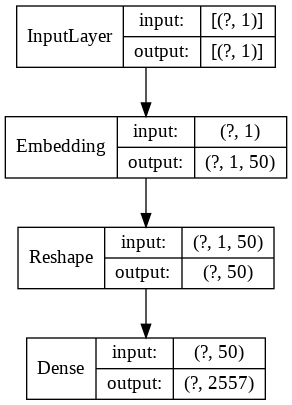

In [0]:
skipgram50=createSkipgram(50)
plot_model(skipgram50, show_shapes = True, show_layer_names=False)

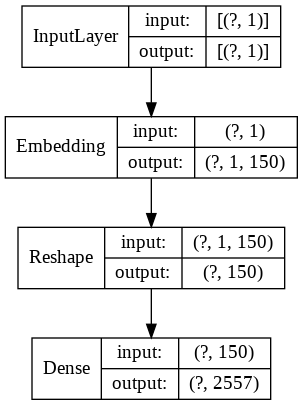

In [0]:
skipgram150=createSkipgram(150)
plot_model(skipgram150, show_shapes = True, show_layer_names=False)

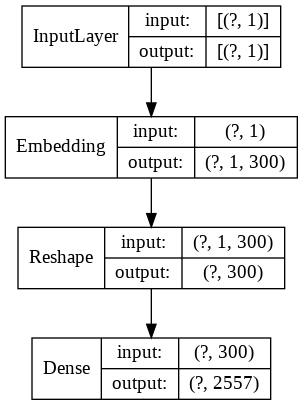

In [0]:
skipgram300=createSkipgram(300)
plot_model(skipgram300, show_shapes = True, show_layer_names=False)

<b>HINT</b>: To increase training speed of your model, you can use the free available GPU power in Google Colab. Go to `Edit` --> `Notebook Settings` --> select `GPU` under `hardware accelerator`.

In [0]:
#TRAINING AND SAVING EMBEDDINGS

#batch size: number of training samples to work through before the model’s internal parameters are updated

#epochs: number of times to work through the entire training dataset

#verbose: how do you want to 'see' the training progress for each epoch.
    #0: nothing;   1:animated progress bar;   2:simply the number of epoch
skipgram50.fit(x,y,batch_size=64,epochs=10,verbose=1)
save_model_embed(skipgram50,"skipgram50")

skipgram150.fit(x,y,batch_size=64,epochs=10,verbose=1)
save_model_embed(skipgram150,"skipgram150")

skipgram300.fit(x,y,batch_size=64,epochs=10,verbose=1)
save_model_embed(skipgram300,"skipgram300")

Epoch 1/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7.8460 - accuracy: 9.8354e-04
Epoch 2/10
1478/1478 [==============================] - 9s 6ms/step - loss: 7.8452 - accuracy: 0.0019
Epoch 3/10
1478/1478 [==============================] - 9s 6ms/step - loss: 7.8443 - accuracy: 0.0065
Epoch 4/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7.8435 - accuracy: 0.0091
Epoch 5/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7.8427 - accuracy: 0.0137
Epoch 6/10
1478/1478 [==============================] - 9s 6ms/step - loss: 7.8418 - accuracy: 0.0193
Epoch 7/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7.8410 - accuracy: 0.0271
Epoch 8/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7.8401 - accuracy: 0.0335
Epoch 9/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7.8393 - accuracy: 0.0397
Epoch 10/10
1478/1478 [==============================] - 8s 6ms/step - loss: 7

## Task 1.2 - CBOW

Build word embeddings of length 50, 150 and 300 using CBOW model.

In [0]:
# prepare data for CBOW
def data_cbow(corpus, window_size, V):
  x=[] #it will save a list of the context words
  y=[]
  context_size=window_size*2
  for words in corpus:
      L = len(words)
      for index, word in enumerate(words):
          
          floor=index-window_size  #lower threshold of the context
          ceiling=index+window_size+1  #higher threshold
          
          context=[words[i] for i in range(floor,ceiling) if 0<=i<L and i!=index]

          x.append(context)
          y.append(to_categorical(word, V))
  x=sequence.pad_sequences(x)
  return np.array(x),np.array(y)

In [0]:
# create training data
x,y=data_cbow(corpus, window_size, V)
print(x.shape)
print(y.shape)


(27165, 4)
(27165, 2557)


In [0]:
def createCBOW(dim):
  cbow=Sequential()
  cbow.add(Embedding(input_dim=V, input_length=window_size*2, output_dim=dim))
  cbow.add(Lambda(lambda x: K.mean(x, axis=1))) #find the average of the embedded words around
  cbow.add(Dense(V,kernel_initializer="glorot_uniform", activation="softmax"))
  cbow.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
  return cbow

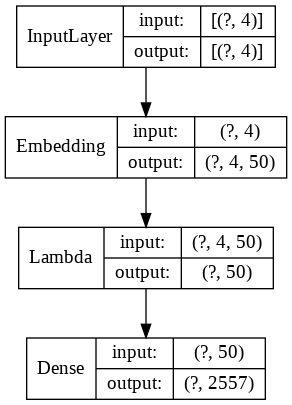

In [0]:
cbow50=createCBOW(50)
plot_model(cbow50, show_shapes = True, show_layer_names=False)

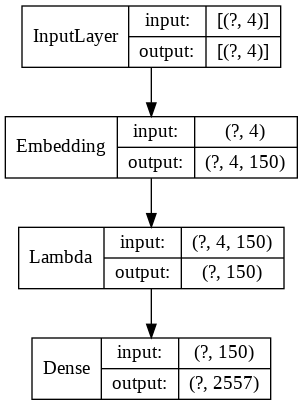

In [0]:
cbow150=createCBOW(150)
plot_model(cbow150, show_shapes = True, show_layer_names=False)

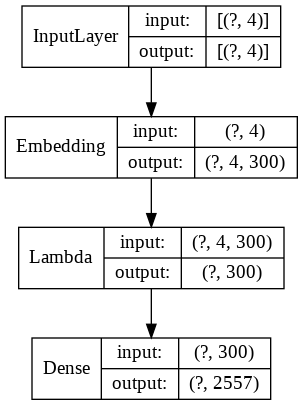

In [0]:
cbow300=createCBOW(300)
plot_model(cbow300, show_shapes = True, show_layer_names=False)

In [0]:
# train CBOW model and save embeddings
cbow50.fit(x,y,batch_size=64,epochs=10,verbose=1)
save_model_embed(cbow50,"CBoW50")

cbow150.fit(x,y,batch_size=64,epochs=10,verbose=1)
save_model_embed(cbow150,"cbow150")

cbow300.fit(x,y,batch_size=64,epochs=10,verbose=1)
save_model_embed(cbow300,"cbow300")

Epoch 1/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8464 - accuracy: 5.8899e-04
Epoch 2/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8462 - accuracy: 8.4668e-04
Epoch 3/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8459 - accuracy: 0.0011
Epoch 4/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8457 - accuracy: 0.0015
Epoch 5/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8454 - accuracy: 0.0023
Epoch 6/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8452 - accuracy: 0.0039
Epoch 7/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8450 - accuracy: 0.0062
Epoch 8/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8447 - accuracy: 0.0092
Epoch 9/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8445 - accuracy: 0.0134
Epoch 10/10
425/425 [==============================] - 2s 6ms/step - loss: 7.8442 - accuracy

## Task 1.3 - Analogy function

Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ( $e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for both CBOW and Skipgram model. This means that for each analogy we have 6 outputs. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`) and a boolean answer whether the predicted word **exactly** equals the true word. 

<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted word (sim2) | Embedding | Correct?|
|------|------|------|------|------|
|  queen is to king as woman is to ?	 | man (sim1) | predictd_word(sim2) | SG_50 | True / False|

* Give at least 5 different  examples of analogies.
* Compare the performance on the analogy s between the word embeddings and briefly discuss your results.

In [0]:
def embed(word, embedding, vocab_size = V, tokenizer=tokenizer):
    # get the index of the word from the tokenizer, i.e. convert the string to it's corresponding integer in the vocabulary
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the one-hot encoding of the word
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding)

def analogy(embedding, name, word1 ,word2, word3,word4):
  #queen,king,woman,man
  #man=king-queen+woman
  #word4 ~ word2-word1+word3
  predictedEmbedding = embed(word2,embedding)-embed(word1,embedding)+embed(word3,embedding)
  sim1=cosine_similarity(predictedEmbedding,embed(word4,embedding))
  sim2=sim1
  predictedWord=word4
  for word,i in tokenizer.word_index.items():
    if(cosine_similarity(predictedEmbedding,embed(word,embedding))>sim2):
      sim2=cosine_similarity(predictedEmbedding,embed(word,embedding))
      predictedWord=word
  return "Analogy: " + str(word1) + " is to " + str(word2) +" as " + str(word3) + " is to ? || True word: " + str(word4) + " (" + str(sim1[0][0]) + ") || Predicted word: "+ str(predictedWord) +" (" + str(sim2[0][0]) + ") || Embedding :"+ str(name) + " || Correct?: " + str(word4==predictedWord)



In [0]:
#load embeddings
embeddingSkip50=skipgram50.get_weights()[0]
embeddingSkip150=skipgram150.get_weights()[0]
embeddingSkip300=skipgram300.get_weights()[0]

embeddingCBOW50=cbow50.get_weights()[0]
embeddingCBOW150=cbow150.get_weights()[0]
embeddingCBOW300=cbow300.get_weights()[0]

In [0]:
#5 different analogies
print(analogy(embeddingSkip50, "SkipGram 50", "england","english","france","french"))
print(analogy(embeddingSkip150, "SkipGram 50", "england","english","france","french"))
print(analogy(embeddingSkip300, "SkipGram 50", "england","english","france","french"))
print(analogy(embeddingCBOW50, "SkipGram 50", "england","english","france","french"))
print(analogy(embeddingCBOW150, "SkipGram 50", "england","english","france","french"))
print(analogy(embeddingCBOW300, "SkipGram 50", "england","english","france","french"))
print("\n")

print(analogy(embeddingSkip50, "SkipGram 50", "queen","king","woman","man"))
print(analogy(embeddingSkip150, "SkipGram 150", "queen","king","woman","man"))
print(analogy(embeddingSkip300, "SkipGram 300", "queen","king","woman","man"))
print(analogy(embeddingCBOW50, "CBOW 50", "queen","king","woman","man"))
print(analogy(embeddingCBOW150, "CBOW 150", "queen","king","woman","man"))
print(analogy(embeddingCBOW300, "CBOW 300", "queen","king","woman","man"))
print("\n")
print(analogy(embeddingSkip50, "SkipGram 50", "he","she","his","her"))
print(analogy(embeddingSkip150, "SkipGram 150", "he","she","his","her"))
print(analogy(embeddingSkip300, "SkipGram 300", "he","she","his","her"))
print(analogy(embeddingCBOW50, "CBOW 50", "he","she","his","her"))
print(analogy(embeddingCBOW150, "CBOW 150", "he","she","his","her"))
print(analogy(embeddingCBOW300, "CBOW 300", "he","she","his","her"))
print("\n")

print(analogy(embeddingSkip50, "SkipGram 50", "man","son","woman","daughter"))
print(analogy(embeddingSkip150, "SkipGram 150", "man","son","woman","daughter"))
print(analogy(embeddingSkip300, "SkipGram 300", "man","son","woman","daughter"))
print(analogy(embeddingCBOW50, "CBOW 50", "man","son","woman","daughter"))
print(analogy(embeddingCBOW150, "CBOW 150", "man","son","woman","daughter"))
print(analogy(embeddingCBOW300, "CBOW 300", "man","son","woman","daughter"))
print("\n")

print(analogy(embeddingSkip50, "SkipGram 50", "up","down","high","low"))
print(analogy(embeddingSkip150, "SkipGram 150", "up","down","high","low"))
print(analogy(embeddingSkip300, "SkipGram 300", "up","down","high","low"))
print(analogy(embeddingCBOW50, "CBOW 50", "up","down","high","low"))
print(analogy(embeddingCBOW150, "CBOW 150", "up","down","high","low"))
print(analogy(embeddingCBOW300, "CBOW 300", "up","down","high","low"))
print("\n")

print(analogy(embeddingSkip50, "SkipGram 50", "is","was","has","had"))
print(analogy(embeddingSkip150, "SkipGram 150", "is","was","has","had"))
print(analogy(embeddingSkip300, "SkipGram 300", "is","was","has","had"))
print(analogy(embeddingCBOW50, "CBOW 50", "is","was","has","had"))
print(analogy(embeddingCBOW150, "CBOW 150", "is","was","has","had"))
print(analogy(embeddingCBOW300, "CBOW 300", "is","was","has","had"))
print("\n") 

Analogy: england is to english as france is to ? || True word: french (0.17204463) || Predicted word: france (0.6135363) || Embedding :SkipGram 50 || Correct?: False
Analogy: england is to english as france is to ? || True word: french (-0.086350076) || Predicted word: france (0.55922043) || Embedding :SkipGram 50 || Correct?: False
Analogy: england is to english as france is to ? || True word: french (-0.112094514) || Predicted word: france (0.5749762) || Embedding :SkipGram 50 || Correct?: False
Analogy: england is to english as france is to ? || True word: french (0.08464741) || Predicted word: english (0.65494204) || Embedding :SkipGram 50 || Correct?: False
Analogy: england is to english as france is to ? || True word: french (0.059909962) || Predicted word: france (0.6178342) || Embedding :SkipGram 50 || Correct?: False
Analogy: england is to english as france is to ? || True word: french (-0.031680834) || Predicted word: france (0.5584538) || Embedding :SkipGram 50 || Correct?: 

# **Analysis**

Both skipgram and cbow fail to predict the word no matter what the dimensions or analogies that we introduce. This is probably due to the fact that all of the neural networks have not been sufficiently trained, therefore the predictions are not very accurate, as it can be seen from the accuracy from each neural network.

If we take a closer look at the predicted words we will notice that, if the analogy is A to B is as C to D, and D is the word we want to predict; it is always B or C reported. This leads us to believe that the analogy function is properly implemented because D should be B-A+C so it does make sense that either B or C is the reported word if the network has not been trained enough. Which is further supported by the fact that the authors use a training sample size of 783 million words in the paper to achieve 50.4 percent accuracy, whereas ours has around 27 thousand.

## Task 1.4 - Discussion
Answer the following question:
* Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?

Skipgram's training data shapes are x.shape = (94556,) and y.shape = (94556, 2557), meaning that x contains 94556 samples and y has  another 94556 of length 2557 each; resulting in a total of 189112 training samples.

This is because the x consists of the 4 context words around every word, 94556/27165 (total number of words) is 3.5 not 4, because there may be sentences with four or fewer words. Also, y is the categorical conversion of all of those words, the converted value is a vector with size equals to the total number of unique words (2557).

Whereas cbow's x.shape = (27165, 4) and y.shape = (27165, 2557), therefore x consists of 27165*4 = 108660 samples, y of 27165 samples of length 2557; which sums up to 135825 training samples.

This is due to each element of x being a list of 4 elements (the context for every word) and y is the categorical conversion of that word. This implies that there are more training data points needed for the skipgram model than for the cbow one. Theoretically this is because for both we need the same amount of samples in x, but for skipgram we are aiming to predict its context so we need to save its categorical conversion in our y variable ; meanwhile for cbow we only need the conversion of the word not the context.